# Tweet Automatic Coding Pipeline

This notebook adds coding to tweets (that were scraped).

In [1]:
import json
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ttest_rel
from collections import Counter
from nltk.tokenize.casual import TweetTokenizer
from nltk import MWETokenizer, pos_tag, RegexpParser
tokenizer = TweetTokenizer()
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer as Stemmer
stemmer = Stemmer()

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

import re
import string
stop = stopwords.words('english') + list(string.punctuation) + ['’', '...', '”', '“', '—', '…']

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# helper functions
def get_words_by_pos_tag(t, pos_tag):
    """ Returns a list of lists where each list contains words that forms a pos_tag in the syntax tree
    """
    try:
        t.label()
    except AttributeError:
        # get the word
        if t[1] == pos_tag:
            return [t[0]]
        else:
            return []
    else:
        # Now we know that t.node is defined
        res = []
        if t.label() == pos_tag:
            res.append(get_list_of_words_in_tree(t))
        else:
            for child in t:
                res += get_words_by_pos_tag(child, pos_tag)
        return res
            
def get_list_of_words_in_tree(t):
    """ Returns a list that contains all words that syntax tree
    """
    try:
        t.label()
    except AttributeError:
        # get the word
        return [t[0]]
    else:
        res = []
        for child in t:
            res += get_list_of_words_in_tree(child)
        return res

# Section 1: Data Preparation

## Read Tweets and Meta Data

In [3]:
tweet_json_file = "../../data/tweets/all_tweets_with_meta.json"
with open(tweet_json_file, 'r') as f:
    long_tweets = json.load(f)

In [4]:
tweets = []
for tweet in long_tweets:
    tweets.append({
        'created_at': tweet['created_at'], 
        'text': tweet['text'],
        'in_reply_to_user_id': tweet['in_reply_to_screen_name'],
        'user': tweet['user']['screen_name'].lower(), 
        'favorite_count': tweet['favorite_count'],
        'retweet_count': tweet['retweet_count'],
        'follower_count': tweet['user']['followers_count'],
        'mentioned_url': [u["expanded_url"] for u in tweet["entities"]["urls"]] if tweet["entities"]["urls"] else [],
        'photo_url': [m["media_url"] for m in tweet["entities"]["media"] if m["type"] == "photo"] if "media" in tweet["entities"] else []})

In [5]:
print("Total tweets: {}".format(len(tweets)))

Total tweets: 29062


## Read Candidate Relations

In [6]:
candidate_jsonlist_file = "../../data/race/2014_us_gubernatorial_election_candidates_with_twitter_and_gender.jsonlist"
candidates = []
with open(candidate_jsonlist_file, 'r') as f:
    for line in f:
        candidates.append(json.loads(line))

In [7]:
state_to_candidates = {}
for c in candidates:
    state = c['state']
    if state not in state_to_candidates:
        state_to_candidates[state] = set()
    state_to_candidates[state].add((c['name'].lower(), c['twitter'].lower()))

In [8]:
# There are candidates who share the same last / first name. 
# In those cases we will omit these tokens. 
twitter_to_word_disambiguation = {}

for state, candidates_in_state in state_to_candidates.items():
    candidates_formatted = [c[0].split() for c in candidates_in_state]
    candidates_twitter = [c[1] for c in candidates_in_state]
    for i, c1 in enumerate(candidates_formatted):
        for j, c2 in enumerate(candidates_formatted):
            if i >= j:
                continue
            for word in c1:
                if word in c2:
                    print("Candidate 1:", candidates_twitter[i])
                    print("Candidate 2:", candidates_twitter[j])
                    print("Ambiguation:", word)
                    print()
                    
                    ct1 = candidates_twitter[i]
                    ct2 = candidates_twitter[j]
                    
                    if ct1 != "":
                        if ct1 not in twitter_to_word_disambiguation:
                            twitter_to_word_disambiguation[ct1] = set()
                        twitter_to_word_disambiguation[ct1].add(word)
                        
                    if ct2 != "":
                        if ct2 not in twitter_to_word_disambiguation:
                            twitter_to_word_disambiguation[ct2] = set()
                        twitter_to_word_disambiguation[ct2].add(word)
                        
# @SeanParnellAK & @mslibertarian talks about "bill" in the context of legislative bills, but his opponent's name is also Bill.
twitter_to_word_disambiguation["seanparnellak"] = set(['bill'])
twitter_to_word_disambiguation["mslibertarian"] = set(['bill'])

twitter_to_word_disambiguation

Candidate 1: 
Candidate 2: 
Ambiguation: chris

Candidate 1: corbettforgov
Candidate 2: tomwolfpa
Ambiguation: tom

Candidate 1: maryburke_01
Candidate 2: burkewigov
Ambiguation: burke



{'corbettforgov': {'tom'},
 'tomwolfpa': {'tom'},
 'maryburke_01': {'burke'},
 'burkewigov': {'burke'},
 'seanparnellak': {'bill'},
 'mslibertarian': {'bill'}}

### Build Opponent Relationship

In [9]:
opponents = {}

# candidate relationship
for c in candidates:
    # key in by twitter handle
    t = c['twitter'].lower()
    if not t:
        continue
    if t not in opponents:
        opponents[t] = set()
        
    state_wide_opponents = state_to_candidates[c['state']]
    for name, twitter in state_wide_opponents:
        if twitter == t:
            continue
        if not twitter:
            continue
        
        opponents[t].add("@" + twitter.lower())
        for name_component in name.split():
            if name_component:
                # see twitter_to_word_disambiguation
                if t in twitter_to_word_disambiguation:
                    if name_component in twitter_to_word_disambiguation[t]:
                        continue
                opponents[t].add(name_component.lower())
        opponents[t].add(name)

# Tom Corbett tags his opponent under a different account
opponents["corbettforgov"].add("@wolfforpa")
# Martha Coakley tags her opponent under a different account
opponents["marthacoakley"].add("@charlieforgov")

In [10]:
for c in candidates:
    # key in by twitter handle
    t = c['twitter'].lower()
    if not t:
        continue
      
    # add possessive form
    possessive = set()
    for o in opponents[t]:
        possessive.add("{}'s".format(o))
    opponents[t].update(possessive)

In [11]:
opponents['howiehawkins']

{'@nygovcuomo',
 "@nygovcuomo's",
 '@robastorino',
 "@robastorino's",
 '@votemcdermott',
 "@votemcdermott's",
 'andrew',
 'andrew cuomo',
 "andrew cuomo's",
 "andrew's",
 'astorino',
 "astorino's",
 'cuomo',
 "cuomo's",
 'mcdermott',
 "mcdermott's",
 'michael',
 'michael mcdermott',
 "michael mcdermott's",
 "michael's",
 'rob',
 'rob astorino',
 "rob astorino's",
 "rob's"}

## Attack Tweets

In [12]:
attacking = []
for tweet in tweets:
    user = tweet['user']
    oppo = opponents[user]
    text = tweet['text']
    
    tokenzied = tokenizer.tokenize(text)
    tokenzied = [token.lower() for token in tokenzied]
    attacking.append(any([o in tokenzied for o in oppo]) or "opponent" in tokenzied)
    
print("{0:.2f}% of tweets are attack tweets".format(100 * attacking.count(True) / len(attacking)))

13.09% of tweets are attack tweets


In [13]:
# get index of these attack tweets
attacking_index = [i for i, a in enumerate(attacking) if a]

In [14]:
for ai in attacking_index[10:20]:
    tweet = tweets[ai]
    user = tweet['user']
    oppo = opponents[user]
    text = tweet['text']
    
    print(text)
    print(oppo)
    print()

@WolfForPA has used “Fuzzy math” on his tax plan. See what @PhillyInquirer had to say about that.  #PAGov http://t.co/B9ia7CG3hu
{'wolf', "@wolfforpa's", "tom wolf's", "@tomwolfpa's", 'tom wolf', '@wolfforpa', '@tomwolfpa', "wolf's"}

.@WolfForPA said gas prices went through roof due to transportation bill.  They didn’t. http://t.co/KbuOk71MtW #pagov #CorbettWolf
{'wolf', "@wolfforpa's", "tom wolf's", "@tomwolfpa's", 'tom wolf', '@wolfforpa', '@tomwolfpa', "wolf's"}

Right now if we follow the Pete Ricketts plan we go to paying the full cost. #TeamHassebrook #NeGov
{'@rickettsforgov', "pete ricketts's", 'pete ricketts', 'pete', 'ricketts', "ricketts's", "@rickettsforgov's", "pete's"}

"@wolfforpa is for legalizing marijuana but you can't buy a bottle of wine at the grocery store"- Lt Governor Cawley #PAGov
{'wolf', "@wolfforpa's", "tom wolf's", "@tomwolfpa's", 'tom wolf', '@wolfforpa', '@tomwolfpa', "wolf's"}

He cut Bright Futures scholarships in half. Scott made it harder to afford c

## Merge Dataset

### + Attacking

In [15]:
for tweet, is_attack in zip(tweets, attacking):
    tweet['is_attack'] = is_attack

### + Geography

In [16]:
candidate_to_state = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_state[t] = c['state']
        
for tweet in tweets:
    tweet['state'] = candidate_to_state[tweet['user']]

### + Gender

In [17]:
candidate_to_gender = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_gender[t] = c['gender']
        
for tweet in tweets:
    tweet['gender'] = candidate_to_gender[tweet['user']]

### + Party

In [18]:
candidate_to_party = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_party[t] = c['party']
        
for tweet in tweets:
    tweet['party'] = candidate_to_party[tweet['user']]

### + Incumbency

In [19]:
candidate_to_incumbency = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_incumbency[t] = c['incumbency']
        
for tweet in tweets:
    tweet['incumbency'] = candidate_to_incumbency[tweet['user']]

### + Competitiveness
Needs to + States first

In [20]:
with open("../../data/race/competitiveness.jsonlist", 'r') as f:
    state_to_competitiveness = json.load(f)

for tweet in tweets:
    state = tweet['state']
    tweet['competitiveness'] = state_to_competitiveness[state]

### + Affect

In [21]:
affect_map_file = "./library/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
affect_map = {}
with open(affect_map_file, 'r') as f:
    for line in f:
        token, affect, score = line.strip().split("\t")
        score = int(score)
        token = stemmer.stem(token)
        if token not in affect_map:
            affect_map[token] = {}
        affect_map[token][affect] = score

In [22]:
affects = set(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'])

tweet_affect_token_ratios = []

for tweet in tweets:
    text = tweet['text']
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = set([stemmer.stem(token) for token in tokens if token not in stop])
    tweet['affects'] = {a: 0 for a in affects}
    tweet['affect_tokens'] = {a: [] for a in affects}
    tweet['viciousness'] = 0
    
    viciousness_tokens = set()
    
    total_tokens = 0.0
    affect_tokens = 0.0
    for t in tokens:
        total_tokens += 1.0
        if t in affect_map:
            affect_tokens += 1.0
            token_affects = affect_map[t]
            for affect, score in token_affects.items():
                if t not in viciousness_tokens:
                    if affect in set(["negative", "disgust", "anger", "fear", "sadness"]):
                        tweet['viciousness'] += score
                        viciousness_tokens.add(t)
                
                tweet['affects'][affect] += score
                if score > 0:
                    tweet['affect_tokens'][affect].append(t)
                
    if total_tokens == 0.0:
        affect_token_ratio = 0.0
    else:
        affect_token_ratio = affect_tokens / total_tokens
    
    tweet_affect_token_ratios.append(affect_token_ratio)
    
print("Mean affect token ratio", np.mean(tweet_affect_token_ratios))
print("Std dev on affect token ratio", np.std(tweet_affect_token_ratios))

Mean affect token ratio 0.487649248367466
Std dev on affect token ratio 0.17964814381153066


In [23]:
# tweet_to_affect_viciousness = [(t["text"], t["affects"]["negative"] + 
#                          t["affects"]["disgust"] + 
#                          t["affects"]["fear"] + 
#                          t["affects"]["anger"]) for t in tweets if t["is_attack"] == 1]

tweet_to_affect_viciousness = [(t["text"], t["viciousness"]) for t in tweets if t["is_attack"] == 1]

In [24]:
sorted_viciousness = sorted(tweet_to_affect_viciousness, key = lambda x : x[1])
sorted_viciousness[:20]

[('Multi-millionaire @WolfForPA thinks middle-class families are “rich like him” &amp; should pay more taxes. http://t.co/YOOIImKQTD #pagov',
  0),
 ('Kind of funny how @WolfForPA brings up line of credit loans, when it was created to fix his mess.  http://t.co/XgjHvF4Ed2 #cbsphillydebate',
  0),
 ('Summing up the race:\n\n—11K jobs created in Sept under Malloy-Wyman\n—@TomFoleyCT won’t talk about his outsourcing of jobs\n\nThat’s it. #ctgov',
  0),
 ('.@TomFoleyCT is refusing to release his state tax returns because they "must be extraordinarily damaging.” http://t.co/ZZwNrDZLFa #ctgov',
  0),
 ('@WolfForPA has used “Fuzzy math” on his tax plan. See what @PhillyInquirer had to say about that.  #PAGov http://t.co/B9ia7CG3hu',
  0),
 ('.@WolfForPA said gas prices went through roof due to transportation bill.  They didn’t. http://t.co/KbuOk71MtW #pagov #CorbettWolf',
  0),
 ('Right now if we follow the Pete Ricketts plan we go to paying the full cost. #TeamHassebrook #NeGov',
  0),
 ('"@

In [25]:
sorted_viciousness[-40:]

[("Women should be able to make personal decisions w/o intrusion of pols like Greg Abbott, who'd ban abortion even for rape and incest. #HB2",
  3),
 (".@NathanDeal's campaign is struggling to come up w/ excuses for why #GA has 50th worst unemployment rate. Their latest doesn't hold up (1/3)",
  3),
 ("Shocking abuse of power from @NathanDeal who ousted 2 board members who Q'd rate increases for his big donors #gapol http://t.co/STQYGstN2M",
  3),
 ('Unacceptable: @GregAbbott_TX wants to ban abortion in cases of rape and incest, which his representative offensively called "minor issues."',
  3),
 ('What was promised to this anti-equality, dark money group from Ohio to dump money in support of @TomFoleyCT? #ctgov http://t.co/hq8herwxL7',
  3),
 ("Mr. Abbott’s support of closing health centers &amp; outlawing abortion in cases of rape &amp; incest shows shocking coldness toward women's issues.",
  3),
 ('.@NYGovCuomo. Stop being a bully. Challenge @ZephyrTeachout at the ballot box, not i

In [26]:
viciousness_to_tweets = {}
for t, v in sorted_viciousness:
    if v not in viciousness_to_tweets:
        viciousness_to_tweets[v] = []
    viciousness_to_tweets[v].append(t)

In [27]:
affect_to_explore = "disgust"

[(tweet["text"], tweet['affect_tokens'][affect_to_explore]) for tweet in sorted(tweets, key = lambda x: -x['affects'][affect_to_explore])][:10]

[("@Rach_IC @BradHubert @brianjsymes Sorry if my honest responses offend you.  I guess I 'viciously attacked' you, again...sigh.",
  ['attack', 'offend', 'vicious', 'honest']),
 ('MT @CarolSOtt I think if you cant win a campaign honestly, w/o lying &amp;attacking your opponent, you dont deserve to win. Vote @Hogan4Governor',
  ['attack', 'lie', 'oppon', 'honest']),
 ('Today we honored Timothy Cole, who was wrongfully convicted of rape and died in prison. Our justice system failed both him and the victim.',
  ['prison', 'rape', 'victim', 'die']),
 (".@ZephyrTeachout. You're right re Quinn's poor record re living wage, sick days. Need $15 hr min wage, action on wage theft. Vote Green.",
  ['theft', 'sick', 'action']),
 ('Bribery, theft of services, racketeering, and tax evasion all involve abuse of taxpayers and tax dollars. #ABNY',
  ['briberi', 'abus', 'theft']),
 ('“@js_newswatch: Final debate gives…” Socrates a nose bleed\n #WIGovDebate',
  ['final', 'nose', 'bleed']),
 ('The concept

# Section 2: Analysis and Methods

## Attack By States

In [28]:
state_to_attack_count = Counter()
state_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    state = tweet['state']
    
    state_to_total_tweets[state] += 1
    
    if is_attack:
        state_to_attack_count[state] += 1

states = list(state_to_total_tweets.keys())        
rates = [state_to_attack_count[state] / state_to_total_tweets[state] for state in states]

df_attack_rate_by_state = pd.DataFrame(index=states, data=rates, columns=["attack_rate"])

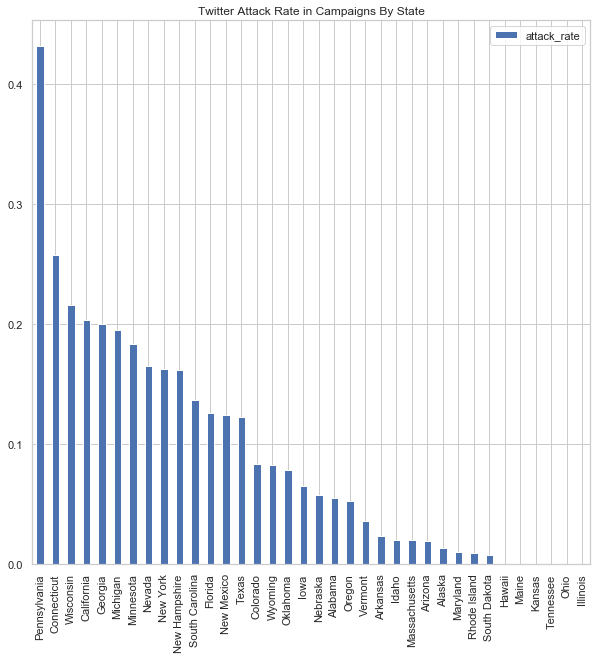

In [80]:
sns.set_style("whitegrid")
ax = df_attack_rate_by_state.sort_values("attack_rate", ascending=False).plot.bar(figsize=(10,10))
plt.title("Twitter Attack Rate in Campaigns By State")
plt.savefig("../../figures/Twitter Attack Rate in Campaigns By State.png")
plt.show()

## Filter Out Penn Tweets

Pennsylvania seems like an outlier which has an extremely high percentage of attack tweets. By excluding it, we see results that conform to previous literture.

The issue with Pennsylvania is that the incumbent Republican Governor Tom Corbett was projected to be beaten by Tom Wolf the Democratic challenger. The Cook Political Report did not deem this race to be even competitive. We can imagine how this might impact incumbents to attack the challenger.


In [30]:
tweets = [tweet for tweet in tweets if tweet['state'] != "Pennsylvania"]
attacking_index = [i for i, a in enumerate(tweets) if a["is_attack"]]

## Attack By Gender

In [31]:
gender_to_attack_count = Counter()
gender_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    gender = tweet['gender']
    
    gender_to_total_tweets[gender] += 1
    
    if is_attack:
        gender_to_attack_count[gender] += 1

genders = list(gender_to_total_tweets.keys())        
rates = [gender_to_attack_count[gender] / gender_to_total_tweets[gender] for gender in genders]

df_attack_rate_by_gender = pd.DataFrame(index=genders, data=rates, columns=["attack_rate"])

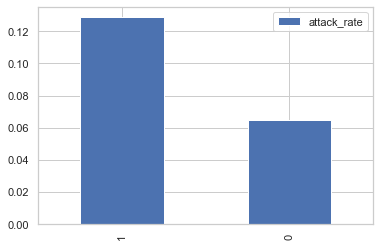

In [32]:
df_attack_rate_by_gender.sort_values("attack_rate", ascending=False).plot.bar()

## Attack By Party

In [33]:
party_to_attack_count = Counter()
party_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    party = tweet['party']
    
    party_to_total_tweets[party] += 1
    
    if is_attack:
        party_to_attack_count[party] += 1

parties = list(party_to_total_tweets.keys())        
rates = [party_to_attack_count[party] / party_to_total_tweets[party] for party in parties]

df_attack_rate_by_party = pd.DataFrame(index=parties, data=rates, columns=["attack_rate"])

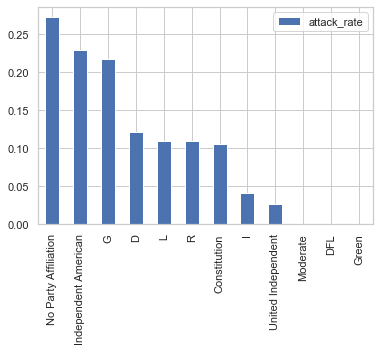

In [34]:
df_attack_rate_by_party.sort_values("attack_rate", ascending=False).plot.bar()

## Attack By Incumbency

In [35]:
incumbency_to_attack_count = Counter()
incumbency_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    incumbency = tweet['incumbency']
    
    incumbency_to_total_tweets[incumbency] += 1
    
    if is_attack:
        incumbency_to_attack_count[incumbency] += 1

incumbencies = list(incumbency_to_total_tweets.keys())        
rates = [incumbency_to_attack_count[incumbency] / incumbency_to_total_tweets[incumbency] for incumbency in incumbencies]

readable_i_mapping = {True: "Incumbent", 
                      False: "Challenger"}

readable_i = [readable_i_mapping[i] for i in incumbencies]
df_attack_rate_by_incumbency = pd.DataFrame(index=readable_i, data=rates, columns=["attack_rate"])

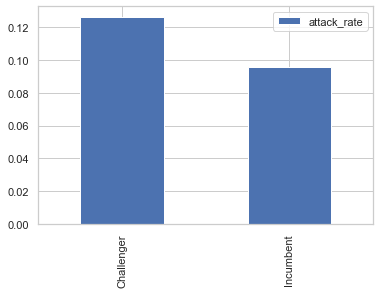

In [36]:
df_attack_rate_by_incumbency.sort_values("attack_rate", ascending=False).plot.bar()

## Attack By Competitiveness

In [37]:
competitiveness_to_attack_count = Counter()
competitiveness_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    competitiveness = tweet['competitiveness']
    
    competitiveness_to_total_tweets[competitiveness] += 1
    
    if is_attack:
        competitiveness_to_attack_count[competitiveness] += 1

competitivenesses = list(competitiveness_to_total_tweets.keys())        
rates = [competitiveness_to_attack_count[competitiveness] / competitiveness_to_total_tweets[competitiveness] for competitiveness in competitivenesses]

readable_c_mapping = {True: "Competitive", 
                      False: "Non-competitive"}

readable_c = [readable_c_mapping[c] for c in competitivenesses]

df_attack_rate_by_competitiveness = pd.DataFrame(index=readable_c, data=rates, columns=["attack_rate"])

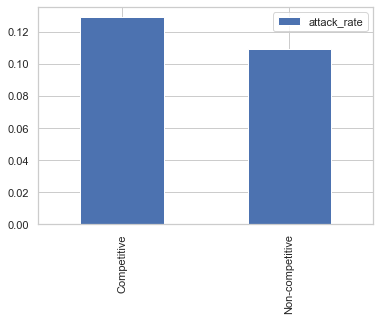

In [38]:
df_attack_rate_by_competitiveness.sort_values("attack_rate", ascending=False).plot.bar()

## Attack by Joint (Competiveness, Incumbency)

In [39]:
ci_to_attack_count = Counter()
ci_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    competitiveness = tweet['competitiveness']
    incumbency = tweet['incumbency']
    
    ci_to_total_tweets[(competitiveness, incumbency)] += 1
    
    if is_attack:
        ci_to_attack_count[(competitiveness, incumbency)] += 1

cies = list(ci_to_total_tweets.keys())        
rates = [ci_to_attack_count[ci] / ci_to_total_tweets[ci] for ci in cies]

readable_ci_mapping = {(True, True): ("Competitive", "Incumbent"), 
                      (True, False): ("Competitive", "Challenger"),
                      (False, True): ("Non-competitive", "Incumbent"),
                      (False, False): ("Non-competitive", "Challenger")}

readable_ci = [readable_ci_mapping[ci] for ci in cies]
df_attack_rate_by_ci = pd.DataFrame(index=readable_ci, data=rates, columns=["attack_rate"])

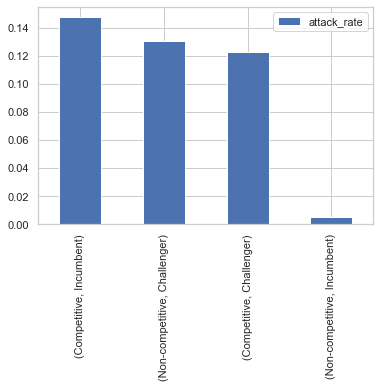

In [40]:
df_attack_rate_by_ci.sort_values("attack_rate", ascending=False).plot.bar()

## Do Attacks Get More Attention?

### Favorites

In [41]:
favs_nonattack = [tweet['favorite_count'] for tweet in tweets if not tweet["is_attack"]]
favs_attack = [tweet['favorite_count'] for tweet in tweets if tweet["is_attack"]]

In [42]:
print("(Nonattack tweets) mean: {0:.2f}, st dev: {1:.2f}".format(np.mean(favs_nonattack), np.std(favs_nonattack)))

(Nonattack tweets) mean: 7.03, st dev: 21.58


In [43]:
print("(Atk tweets) mean: {0:.2f}, st dev: {1:.2f}".format(np.mean(favs_attack), np.std(favs_attack)))

(Atk tweets) mean: 8.29, st dev: 23.64


In [44]:
ttest_ind(favs_nonattack, favs_attack, equal_var=False)

Ttest_indResult(statistic=-2.935886930454845, pvalue=0.0033441641606675675)

### Retweets

In [45]:
retweets_nonattack = [tweet['retweet_count'] for tweet in tweets if not tweet["is_attack"]]
retweets_attack = [tweet['retweet_count'] for tweet in tweets if tweet["is_attack"]]

In [46]:
print("(Nonattack tweets) mean: {0:.2f}, st dev: {1:.2f}".format(np.mean(retweets_nonattack), np.std(retweets_nonattack)))

(Nonattack tweets) mean: 8.49, st dev: 21.69


In [47]:
print("(Atk tweets) mean: {0:.2f}, st dev: {1:.2f}".format(np.mean(retweets_attack), np.std(retweets_attack)))

(Atk tweets) mean: 14.44, st dev: 32.93


In [48]:
ttest_ind(retweets_nonattack, retweets_attack, equal_var=False)

Ttest_indResult(statistic=-10.179309853362073, pvalue=5.0019985044647845e-24)

From the t-test results, attack tweets do get more favorites and retweets. 

**TODO: How to account for different candidates who might have different popularities on Twitter.**

## Distiguishing Ad Hominem Attacks

### Vocab

In [49]:
vocab = Counter()
for tweet_index in attacking_index:
    tweet = tweets[tweet_index]
    text = tweet['text']
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens if token not in stop]
    vocab.update(tokens)
counts = [c for _, c in vocab.most_common()]

In [50]:
len(vocab)

7412

In [51]:
print("Vacab counts: max is {} and min is {}".format(max(counts), min(counts)))

Vacab counts: max is 487 and min is 1


In [52]:
print("Vocab counts: {}th percentile is: {}".format(80, np.percentile(counts, 80)))

Vocab counts: 80th percentile is: 4.0


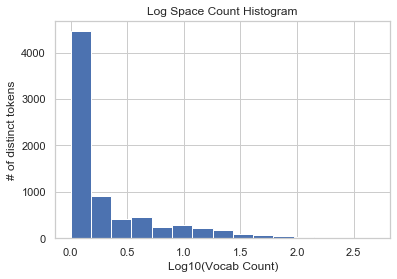

In [53]:
plt.hist(np.log10(counts), bins = 15)
plt.title("Log Space Count Histogram")
plt.ylabel("# of distinct tokens")
plt.xlabel("Log10(Vocab Count)")
plt.show()

In [54]:
%%script false --no-raise-error

# export words for coding
token_coding_file = "../../data/token_coding/token_coding_init.csv"
with open(token_coding_file, 'w') as f:
    f.write("count,token,is_policy\n")
    for token, count in vocab.most_common():
        f.write("{}, {}, {}\n".format(count, token, ""))

In [55]:
#%%script false --no-raise-error

policy_percentages = []
num_tokens = list(range(0, 2020, 20))

# plot to see if we have coded enough
for i in tqdm_notebook(num_tokens):
    token_coding_finished_file = "../../data/token_coding/token_coding.csv"
    c = 0
    policy_tokens = set()
    with open(token_coding_finished_file, 'r') as f:
        f.readline()
        for line in f:
            coded_line = line.strip().split(",")[:-1]
            if c >= i:
                break
            if coded_line[-1] == "1":
                policy_tokens.add(coded_line[1].strip())
            c += 1
            
    is_policies_token_based = []
    for tweet_index in attacking_index:
        tweet = tweets[tweet_index]
        text = tweet['text']
        tokens = tokenizer.tokenize(text)
        tokens = [token.lower() for token in tokens]
        tokens = [stemmer.stem(token) for token in tokens if token not in stop]
        is_policy = any([token in policy_tokens for token in tokens])
        is_policies_token_based.append(is_policy)
        
    pc = sum(is_policies_token_based)
    tc = len(is_policies_token_based)
    policy_percentages.append(pc / tc)

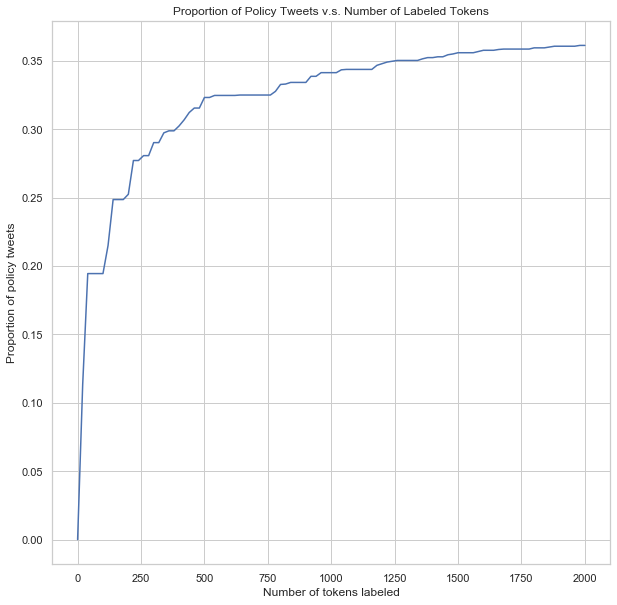

In [79]:
#%%script false --no-raise-error

plt.figure(figsize = (10,10))
plt.plot(num_tokens, policy_percentages)
plt.xlabel("Number of tokens labeled")
plt.ylabel("Proportion of policy tweets")
plt.title("Proportion of Policy Tweets v.s. Number of Labeled Tokens")

plt.savefig("../../figures/Proportion of Policy Tweets wv Number of Labeled Tokens.png")

plt.show()

In [57]:
token_coding_finished_file = "../../data/token_coding//token_coding.csv"
c = 0
policy_tokens = set()
with open(token_coding_finished_file, 'r') as f:
    f.readline()
    for line in f:
        coded_line = line.strip().split(",")[:-1]
        if coded_line[-1] == "":
            break
        if coded_line[-1] == "1":
            policy_tokens.add(coded_line[1].strip())
        c += 1
print("{} tokens labeled".format(c))
print("{} policy tokens".format(len(policy_tokens)))

2000 tokens labeled
66 policy tokens


In [58]:
policy_tokens

{'#ebola',
 '#raisethewag',
 '#vergara',
 'aca',
 'amend',
 'assault',
 'border',
 'china',
 'classroom',
 'climat',
 'commerc',
 'commerci',
 'constitut',
 'debt',
 'doctor',
 'ebola',
 'econom',
 'economi',
 'educ',
 'environ',
 'epa',
 'financ',
 'financi',
 'gun',
 'hca',
 'health',
 'healthcar',
 'hurrican',
 'immigr',
 'industri',
 'infrastructur',
 'insur',
 'israel',
 'job',
 'kid',
 'loan',
 'manufactur',
 'marijuana',
 'medic',
 'medicaid',
 'medicar',
 'mexico',
 'middle-class',
 'obamacar',
 'pension',
 'poverti',
 'prison',
 'pro-gun',
 'rape',
 'safeti',
 'school',
 'student',
 'suprem',
 'surgeon',
 'tax',
 'tax-fre',
 'taxpay',
 'teacher',
 'unemploy',
 'union',
 'univers',
 'veteran',
 'wage',
 'wealthi',
 'women',
 'work'}

In [59]:
is_policies_token_based = []
for tweet_index in attacking_index:
    tweet = tweets[tweet_index]
    text = tweet['text']
    tokens = tokenizer.tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens if token not in stop]
    is_policy = any([token in policy_tokens for token in tokens])
    is_policies_token_based.append(is_policy)

In [60]:
text = "Latest example of @GregAbbott_TX working for insiders: siding w/ his donor against patients who died or were maimed by a sociopath surgeon."
tokens = tokenizer.tokenize(text)
tokens = [token.lower() for token in tokens]
tokens = [stemmer.stem(token) for token in tokens if token not in stop]

In [61]:
[(token, token in policy_tokens) for token in tokens]

[('latest', False),
 ('exampl', False),
 ('@gregabbott_tx', False),
 ('work', True),
 ('insid', False),
 ('side', False),
 ('w', False),
 ('donor', False),
 ('patient', False),
 ('die', False),
 ('maim', False),
 ('sociopath', False),
 ('surgeon', True)]

In [62]:
pc = sum(is_policies_token_based)
tc = len(is_policies_token_based)
ttc = len(tweets)

print("Total policy tweets: {} out of {} attack tweets ({:.2f}%)".format(pc, tc, pc / tc * 100))
print("Total policy tweets: {} out of {} total tweets ({:.2f}%)".format(pc, ttc, pc / ttc * 100))

Total policy tweets: 1215 out of 3364 attack tweets (36.12%)
Total policy tweets: 1215 out of 28042 total tweets (4.33%)


In [63]:
for ai, p in zip(attacking_index, is_policies_token_based):
    text = tweets[ai]['text']
    if p:
        print(text)
        print()

Summing up the race:

—11K jobs created in Sept under Malloy-Wyman
—@TomFoleyCT won’t talk about his outsourcing of jobs

That’s it. #ctgov

.@TomFoleyCT is refusing to release his state tax returns because they "must be extraordinarily damaging.” http://t.co/ZZwNrDZLFa #ctgov

Why did @NYGovCuomo let Sheldon Silver off the hook in Albany sex assault scandals? @WomensEqParty #womensequality #votewep

We can't catch a break in Hassan's Walking Dead economy!

Click here if you agree: http://t.co/c2JPu0Kgr8
#nhpolitics http://t.co/DZbkiXY4lz

My record of support for sexual assault survivors speaks for itself. @GregAbbott_TX can't keep his story straight: http://t.co/oc47w0rdyb

Good that criticism forced .@nyGovCuomo to walk back #Ebola quarantine. Needs to apologize for misinfo, behavior. http://t.co/YvyXHYQzgg

Q6 Obamacare. Abbott: wants block grants from fed gov &amp; more $ on womens care. Davis:Texas sends too much $ to DC... http://t.co/1AcaHdzFtr

Dinner out more expensive? You c

In [64]:
# append references
for ai, ip in zip(attacking_index, is_policies_token_based):
    tweets[ai]["is_policy"] = ip

for tweet in tweets:
    if "is_policy" not in tweet:
        tweet["is_policy"] = False

### References

In [65]:
# gather all pronoun tags
pos_tag_to_include = set(["PRP", "PRP$"])

prp_set = set()

startswithany = lambda x, y: any([x.startswith(yy) for yy in y])

for ai in attacking_index:
    tweet = tweets[ai]
    text = tweet["text"]
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if not startswithany(token, set(["#", "@", "http"]))]
    pos_tags = [pos for _, pos in pos_tag(tokens)]
    prp_set.update([token.lower() for token, pos in zip(tokens, pos_tags) if (pos in pos_tag_to_include)])

In [66]:
# these references are obtained through NLTK code above
us_ref = set([
 'my',
 'our'
])

them_ref = set([
 'her',
 'his',
 'their'
])

In [67]:
is_contrast = []

for i, ai in enumerate(attacking_index):
    # must be a policy tweet to have contrast
    if not is_policies_token_based[i]:
        is_contrast.append(False)
        continue
    
    tweet = tweets[ai]
    text = tweet["text"]
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if not startswithany(token, set(["#", "@", "http"]))]
    pos_tags = [pos for _, pos in pos_tag(tokens)]
    tokens = [token.lower() for token, pos in zip(tokens, pos_tags) if (pos in pos_tag_to_include)]
    is_us = any([us_token in tokens for us_token in us_ref])
#     is_them = any([us_token in tokens for us_token in them_ref])
    is_contrast.append(is_us)

In [68]:
cc = sum(is_contrast)
tc = len(is_contrast)
print("Total contrast tweets wrt all tweets: {} out of {} ({:.2f}%)".format(cc, tc, cc / tc * 100))
print("Total contrast tweets wrt policy tweets: {} out of {} ({:.2f}%)".format(cc, pc, cc / pc * 100))

Total contrast tweets wrt all tweets: 130 out of 3364 (3.86%)
Total contrast tweets wrt policy tweets: 130 out of 1215 (10.70%)


In [69]:
for ai, c in zip(attacking_index, is_contrast):
    text = tweets[ai]['text']
    if c:
        print(text)
        print()

My record of support for sexual assault survivors speaks for itself. @GregAbbott_TX can't keep his story straight: http://t.co/oc47w0rdyb

One county, one school district? My opponent gets an "F" on his plans for education. http://t.co/flTpFQ3yFg #negov

Mr. Abbott: Where’s the justice for our veterans? Why side against them by giving payday lenders the green light? http://t.co/4fOY6NFbTD

Wendy is wrong. Texas (mis)spends half our budget/$100 billion on education. Too much! http://t.co/MnJo2ft91T

As governor I plan to get Maggie Hassan's sluggish economy moving again. 
Read my plan here: http://t.co/Y7VJf7bStp http://t.co/6zHeGZxH0p

Texans deserve to know the truth – @GregAbbott_TX sided with a company over a rape victim. Watch my first TV ad now: http://t.co/HSG6ItRsxC

Are you ready to end the Fallin and Barresi era and elect a Governor who cares about education and our state? https://t.co/n2cjU4Ph0e

“@SpudLovr: Mary Burke on Medicaid funds: "This is money Wisconsinites pay as ta

In [70]:
# append references
for ai, ic in zip(attacking_index, is_contrast):
    tweets[ai]["is_contrast"] = ic

for tweet in tweets:
    if "is_contrast" not in tweet:
        tweet["is_contrast"] = False

### Language: Attack Affect

In [71]:
# %%script false --no-raise-error

df_affect_tweets = pd.DataFrame(columns = ['is_attack'] + [affect for affect in affects])
for tweet in tqdm_notebook(tweets):
    tweet_affects = tweet['affects']
    is_attack = tweet['is_attack']
    row = {a : s for a, s in tweet_affects.items()}
    row['is_attack'] = is_attack
    df_affect_tweets = df_affect_tweets.append(row, ignore_index = True)
    
# change data type to get correlations
df_affect_tweets['is_attack'] = df_affect_tweets['is_attack'].astype('int')
for a in affects:
    df_affect_tweets[a] = df_affect_tweets[a].astype('int')
    
df_affect_tweets.corr(method = "kendall")[['is_attack']]

,is_attack
is_attack,1.000000
negative,0.198731
fear,0.156001
positive,-0.042605
joy,-0.113220
sadness,0.198145
surprise,-0.035306
trust,-0.017314
anticipation,-0.018072
disgust,0.196700


In [72]:
affect_tokens = {a: set() for a in affects}

for t in tweets:
    for a in affect_tokens:
        affect_tokens[a].update(t["affect_tokens"][a])
    print(t["affect_tokens"]["disgust"])

['action']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['final']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['celebr']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exclus', 'lawsuit']
[]
[]
['social']
[]
[]
['celebr']
['treat']
[]
[]
[]
[]
[]
[]
['dead']
[]
[]
[]
[]
[]
[]
['oppon']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['dead']
[]
[]
[]
['bureaucrat']
[]
[]
['critic']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['crimin']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['air']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['censor']
[]
[]
[]
['prosecut']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['final']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['boy']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['hog']
[]
[]
[]
[]
[]
[]
[]
['critic']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['detest']
[]
[]
[]
[]
[]
[]
['rape']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['social']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['lone']
[]
[]
['victim']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


[]
['final']
[]
[]
[]
['social']
[]
[]
[]
['aw']
[]
['oppon']
[]
['john']
[]
['dead']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['oppon']
[]
[]
['fleec']
[]
['remain', 'victim']
[]
['offend']
[]
['corrupt', 'victim']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['disast']
['mess']
[]
[]
[]
['lesser']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['steal', 'wast']
[]
[]
[]
[]
[]
[]
[]
['lawyer']
[]
[]
['action']
['failur', 'honest']
[]
[]
[]
[]
[]
[]
[]
[]
['lie']
[]
['action']
['smell']
[]
[]
[]
[]
[]
[]
['dead']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['insult']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['devil', 'burk']
[]
['suppress', 'action']
[]
[]
[]
[]
[]
[]
['indiffer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['disast']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['honest']
[]
['celebr']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['celebr']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['celebr']
[]
[]
[]
[]
[]
['failur']
[]
[]
[]
[]
[]
[]


[]
[]
[]
[]
['final']
[]
[]
[]
[]
['offens']
[]
[]
[]
[]
[]
[]
['weird']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['honest']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['mess']
[]
[]
[]
[]
[]
['treat']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['action']
[]
[]
['poverti']
[]
[]
[]
[]
[]
[]
['sour']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['failur']
[]
[]
[]
[]
[]
[]
['crimin']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['corrupt']
['air']
[]
[]
[]
[]
[]
[]
['cancer']
['bogus']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['lie']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['air']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['remain']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['attack']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['final']
[]
['crimin']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['betray']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['woefull

[]
[]
[]
[]
['rage']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['failur']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['burk']
[]
[]
['alcohol']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['grate']
['dead']
[]
[]
[]
[]
[]
[]
[]
['tariff']
['discrimin']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['burk', 'action', 'plagiar']
[]
[]
[]
['burk']
[]
[]
[]
['evil', 'lesser']
[]
[]
[]
[]
[]
[]
['critic']
[]
[]
[]
[]
[]
[]
[]
['john']
['evil', 'lesser']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['owe']
[]
[]
[]
['owe']
[]
['rob']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['air']
[]
[]
[]
['cancer']
[]
[]
[]
[]
[]
[]
['action']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['boy']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['victim']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['dead']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['disgust']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['vi

[]
[]
[]
[]
[]
[]
[]
[]
[]
['wast']
[]
[]
[]
[]
[]
[]
[]
[]
['grate']
[]
[]
[]
['poverti']
[]
[]
[]
[]
['blame']
['wast']
[]
[]
[]
['final']
[]
['final']
[]
[]
[]
[]
['misguid']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['burk']
[]
[]
[]
['lesser', 'oppon']
[]
[]
[]
['rape']
['inconveni']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['kite']
[]
[]
[]
['celebr']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['evil', 'lesser']
[]
[]
['appal']
[]
[]
[]
[]
['death']
[]
[]
[]
[]
['grate']
[]
[]
['air']
[]
[]
[]
[]
[]
['lesser']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['dead']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['disast']
[]
[]
[]
[]
['dirt']
[]
[]
[]
['disast']
['final', 'critic']
['rob']
[]
[]
['lawyer']
[]
[]
[]
['failur', 'burk']
[]
[]
[]
[]
[]
['congress']
[]
[]
[]
['final']
[]
['owe']
[]
[]
[]
['final', 'bad']
[]
[]
[]
[]
[]
[]
[]
[]
['final']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['honest']
[]
[]
['attack']
[]
['cancer']
[]
[]
[]
[]
['evil', 'les

[]
[]
[]
['burk']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['recess']
['attack', 'threaten']
[]
['disast']
[]
[]
[]
[]
[]
['boy']
[]
['inmat']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['bad']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['punish']
[]
[]
['burk']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['elimin', 'rape', 'prosecut']
[]
[]
[]
[]
[]
[]
[]
[]
['treat']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['tree']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['john']
[]
[]
[]
[]
[]
[]
['steal', 'dictatorship']
[]
[]
[]
[]
[]
[]
['suppress']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['disast']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['oppon']
[]
[]
[]
[]
[]
[]
[]
['celebr']
[]
[]
[]
[]
[]
[]
['pollut']
[]
['blame']
['indiffer']
[]
['feel']
[]
[]
[]
[]
['hypocrit', 'critic']
[]
[]
[]
[]
['rape', 'elimin']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['ridicul']
[]
[]
[]
[]
[]
[]
['celebr', 'strip']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['lawsuit']

[]
[]
[]
[]
[]
[]
[]
[]
[]
['wast']
['dandi']
[]
[]
[]
[]
['grate']
[]
[]
[]
[]
['air']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['congress']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['feel']
['suppress']
[]
[]
[]
['action']
[]
['oppon']
[]
[]
[]
[]
[]
[]
['dead', 'oppon']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['action']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['lie']
[]
[]
[]
[]
[]
[]
['erad', 'poverti']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['theft', 'action']
['treat']
['corrupt']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['john']
[]
[]
[]
[]
[]
['blame']
[]
[]
[]
[]
[]
['burk']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['owe']
['betray']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['celebr']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['disast']
[]
[]
[]
[]
[]
[]
[]
['dead']
[]
[]
[]
[]
[]
[]
['poverti']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['oppon']
[]
[]
[]
[]
[]
[]
[]
[]
['rob']
[]
[]
[]
[]
[]
[]
[]
['john']
[]
[]
[]
[]
[]
[]
['lesser']
[]
[]
['celebr']
[]
[]
['attack'

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['burk']
[]
[]
[]
[]
['lie', 'blatant', 'liar']
['burk']
[]
[]
[]
[]
[]
[]
[]
[]
['treat']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['burk', 'critic']
['discrimin']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['dead']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['prison', 'failur', 'offend']
[]
[]
['honest']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['oppon']
[]
[]
[]
[]
[]
[]
['suffer']
[]
[]
[]
['trickeri']
['corrupt']
[]
[]
[]
[]
['final']
[]
['disgust']
[]
[]
[]
[]
[]
[]
[]
[]
['action']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['john']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['crimin']
[]
[]
[]
[]
['social']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['evil', 'lesser']
[]
[]
[]
[]
['dead']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


['john']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['pollut']
['air']
[]
[]
[]
[]
[]
['cancer']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['air']
[]
[]
['attack', 'burk']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['abus', 'action']
[]
['disast']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['critic']
[]
[]
[]
[]
[]
[]
[]
['burk']
[]
[]
[]
[]
[]
[]
['treat']
['honest']
[]
[]
[]
[]
['bad']
['bad']
['victim']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['final']
[]
[]
['celebr']
['quack']
[]
[]
['oppon']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['critic']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['disapprov']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['dead']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['shack']
[]
[]
[]
[]
['corrupt']
[]
[]
[]
[]
[]
[]
[]
['cheat']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['incarcer']
['attack']
['final']
[]
[]

In [73]:
len(affect_tokens["negative"])

1014

## Export

In [74]:
export_json_file = "../../data/tweets/all_tweets_with_coding.json"
with open(export_json_file, 'w') as f:
    json.dump(tweets, f)